In [113]:
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from basis.src.basis import BasalIceStratigrapher
from basis.src.tvd_advection import AdvectTVD

In [32]:
# Initialize the model
BIS = BasalIceStratigrapher()
BIS.initialize('./experiments/static-effective-pressure/input_file.toml')

BIS.grid.at_node['ice_thickness'][:] = np.ravel(gaussian_filter(BIS.grid.at_node['ice_thickness'].reshape(BIS.grid.shape), sigma = 1, mode = 'constant'))
BIS.grid.at_node['surface_elevation'][:] = np.ravel(gaussian_filter(BIS.grid.at_node['surface_elevation'].reshape(BIS.grid.shape), sigma = 1, mode = 'constant'))
BIS.grid.at_node['sliding_velocity_x'][:] = np.ravel(gaussian_filter(BIS.grid.at_node['sliding_velocity_x'].reshape(BIS.grid.shape), sigma = 1, mode = 'constant'))
BIS.grid.at_node['sliding_velocity_y'][:] = np.ravel(gaussian_filter(BIS.grid.at_node['sliding_velocity_y'].reshape(BIS.grid.shape), sigma = 1, mode = 'constant'))

basal_water_pressure = 0.9 * (
    BIS.grid.at_node['ice_thickness'] * BIS.params['ice_density'] * BIS.params['gravity']
)
BIS.set_value('basal_water_pressure', basal_water_pressure)

BIS.set_value('sliding_velocity_y', BIS.grid.at_node['sliding_velocity_y'][:] * -1)

BIS.calc_effective_pressure()
BIS.calc_shear_stress()
BIS.calc_erosion_rate()
BIS.calc_melt_rate()

# Identify terminus nodes
dx = BIS.grid.dx
dy = BIS.grid.dy
bounds = [50 * dx, 100 * dx, 0 * dy, 15 * dy]
BIS.identify_terminus(bounds, depth = 3)

# Start with initial sediment package
initial_till = np.full(BIS.grid.number_of_nodes, 40)
BIS.set_value('till_thickness', initial_till)

initial_fringe = np.full(BIS.grid.number_of_nodes, 1e-3)
BIS.set_value('fringe_thickness', initial_fringe)

initial_dispersed = np.full(BIS.grid.number_of_nodes, 1e-9)
BIS.set_value('dispersed_layer_thickness', initial_dispersed)

In [33]:
# Spin-up the sediment entrainment module
for t in range(100):
    BIS.entrain_sediment(t * 1e-2)
    
for t in range(100):
    BIS.entrain_sediment(t)

for t in range(100):
    BIS.entrain_sediment(100)
    BIS.time_elapsed += 100
    
for t in range(25000):
    dt = BIS.sec_per_a / 1000
    BIS.entrain_sediment(dt)
    BIS.time_elapsed += dt

    if t % 5000 == 0:
        print('Completed step #' + str(t))
    
print('Completed spin-up: ' + str(np.round(BIS.time_elapsed / BIS.sec_per_a, 2)) + ' years elapsed.')

mask, Qf, Qd = BIS.calc_sediment_flux()
print('Qf = ' + str(Qf * 2700 / 1e3))
print('Qd = ' + str(Qd * 2700 / 1e3))

Completed step #0
Completed step #500
Completed step #1000
Completed step #1500
Completed step #2000
Completed step #2500
Completed step #3000
Completed step #3500
Completed step #4000
Completed step #4500
Completed step #5000
Completed step #5500
Completed step #6000
Completed step #6500
Completed step #7000
Completed step #7500
Completed step #8000
Completed step #8500
Completed step #9000
Completed step #9500
Completed step #10000
Completed step #10500
Completed step #11000
Completed step #11500
Completed step #12000
Completed step #12500
Completed step #13000
Completed step #13500
Completed step #14000
Completed step #14500
Completed step #15000
Completed step #15500
Completed step #16000
Completed step #16500
Completed step #17000
Completed step #17500
Completed step #18000
Completed step #18500
Completed step #19000
Completed step #19500
Completed step #20000
Completed step #20500
Completed step #21000
Completed step #21500
Completed step #22000
Completed step #22500
Completed st

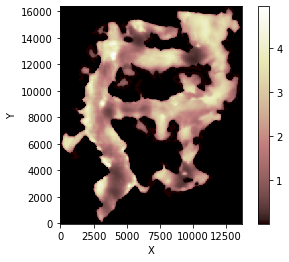

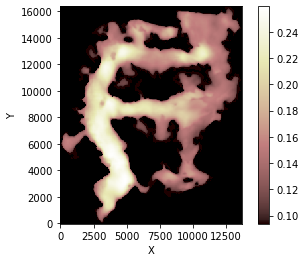

In [35]:
imshow_grid(BIS.grid, 'fringe_thickness')
plt.show()
imshow_grid(BIS.grid, 'dispersed_layer_thickness')
plt.show()

In [265]:
gaussian_fringe = gaussian_filter(BIS.grid.at_node['fringe_thickness'].reshape(BIS.grid.shape), sigma = 1, mode = 'constant')
gaussian_disp = gaussian_filter(BIS.grid.at_node['dispersed_layer_thickness'].reshape(BIS.grid.shape), sigma = 1, mode = 'constant')

init_fringe = np.ravel(gaussian_fringe)
init_dispersed = np.ravel(gaussian_disp)

ux = BIS.grid.map_mean_of_link_nodes_to_link('sliding_velocity_x')
uy = BIS.grid.map_mean_of_link_nodes_to_link('sliding_velocity_y')

velocity = np.zeros(BIS.grid.number_of_links)

velocity = np.where(
    np.isin(np.arange(BIS.grid.number_of_links), BIS.grid.horizontal_links),
    ux,
    uy
)

BIS.grid.add_field('velocity_links', velocity, at = 'link', clobber = True)

dts = np.linspace(5e5, 5e6, 10)
dts = [1e6]

for dt in dts:
    model = BasalIceStratigrapher()
    model.initialize('./experiments/static-effective-pressure/input_file.toml')
    
    z0 = model.params['critical_depth']
    z0 = model.grid.at_node['ice_thickness']
    z0[z0 < 10] = 10

    basal_water_pressure = 0.9 * (
        model.grid.at_node['ice_thickness'] * model.params['ice_density'] * model.params['gravity']
    )
    model.set_value('basal_water_pressure', basal_water_pressure)

    model.set_value('sliding_velocity_y', model.grid.at_node['sliding_velocity_y'][:] * -1)

    model.calc_effective_pressure()
    model.calc_shear_stress()
    model.calc_erosion_rate()
    model.calc_melt_rate()

    # Identify terminus nodes
    dx = model.grid.dx
    dy = model.grid.dy
    bounds = [50 * dx, 100 * dx, 0 * dy, 15 * dy]
    model.identify_terminus(bounds, depth = 3)
    
    outflow = model.grid.add_field(
        'terminus_velocity', 
        model.grid.at_node['is_terminus'][:] * model.grid.at_node['sliding_velocity_magnitude'][:],
        at = 'node'
    )

    # Start with initial sediment package
    initial_till = np.full(model.grid.number_of_nodes, 40)
    model.set_value('till_thickness', initial_till)

    model.set_value('fringe_thickness', init_fringe)

    model.set_value('dispersed_layer_thickness', init_dispersed)
    
    model.grid.add_field('velocity_links', velocity, at = 'link', clobber = True)

    advector = AdvectTVD(model.grid, 'fringe_thickness', 'velocity_links')
    advect_disp = AdvectTVD(model.grid, 'dispersed_layer_thickness', 'velocity_links')
    
    test_courant = np.max(np.abs(advector.calc_courant(advector._grid, advector._vel, dt)))
    print('CFL condition = ' + str(test_courant))
    if test_courant > 1:
        print('Advection likely unstable under CFL condition.')
        
    end_year = 250
    n_steps = int(np.ceil(model.sec_per_a * end_year / dt))
    
    for i in range(n_steps):
        
        advector.update(dt)
        advect_disp.update(dt)
        model.entrain_sediment(dt, clip = 99)
        model.time_elapsed += dt
        
        # Introduce outflow condition
        Hd = model.grid.at_node['dispersed_layer_thickness'][:]
        
        Hd[outflow > 0] -= (
            (Hd[outflow > 0] / model.grid.dx) * outflow[outflow > 0]
        ) * dt
        Hd[Hd < 0] = 0.0
        
        # Smooth values above the 99th percentile
        cut = 99
        
        kernel = np.ones((3, 3)) / 8
        kernel[1, 1] = 0
        Hf = model.grid.at_node['fringe_thickness'][:]
        convolution = np.ravel(convolve2d(Hf.reshape(model.grid.shape), kernel, mode = 'same'))
        Hf[Hf > np.percentile(Hf, cut)] = convolution[Hf > np.percentile(Hf, cut)]
        
        convolution = np.ravel(convolve2d(Hd.reshape(model.grid.shape), kernel, mode = 'same'))
        Hd[Hd > np.percentile(Hd, cut)] = convolution[Hd > np.percentile(Hd, cut)]

        if i % 100 == 0:
            print('Completed step ' + str(i))
            
            gaussian_fringe = gaussian_filter(model.grid.at_node['fringe_thickness'].reshape(model.grid.shape), sigma = 1, mode = 'constant')
            model.grid.at_node['fringe_thickness'][:] = np.ravel(gaussian_fringe)

            gaussian_disp = gaussian_filter(model.grid.at_node['dispersed_layer_thickness'].reshape(model.grid.shape), sigma = 1, mode = 'constant')
            model.grid.at_node['dispersed_layer_thickness'][:] = np.ravel(gaussian_disp)
            
            __, Qf, Qd = model.calc_sediment_flux()
            Qfs.append(Qf)
            Qds.append(Qd)
            
        # if i % 1000 == 0:
#             imshow_grid(model.grid, 'fringe_thickness')
#             plt.title('Frozen fringe (m)')
#             plt.show()
            
#             imshow_grid(model.grid, 'dispersed_layer_thickness')
#             plt.title('Dispersed layer (m)')
#             plt.show()
            
#             plt.plot(Qfs)
#             plt.show()
            
#             plt.plot(Qds)
#             plt.show()
            
print('Completed simulation with dt = ' + str(int(dt)) + ' s.')    
    
np.savetxt('./experiments/advection-parameters/output/fringe_' + str(int(dt)) + 's.txt', model.grid.at_node['fringe_thickness'][:])
np.savetxt('./experiments/advection-parameters/output/dispersed_' + str(int(dt)) + 's.txt', model.grid.at_node['dispersed_layer_thickness'][:])

np.savetxt('./experiments/advection-parameters/output/fringe_flux_' + str(int(dt)) + 's.txt', Qfs)
np.savetxt('./experiments/advection-parameters/output/dispersed_flux_' + str(int(dt)) + 's.txt', Qds)

CFL condition = 0.211132901313
Completed step 0
Completed step 100
Completed step 200
Completed step 300
Completed step 400
Completed step 500
Completed step 600
Completed step 700
Completed step 800
Completed step 900
Completed step 1000
Completed step 1100
Completed step 1200
Completed step 1300
Completed step 1400
Completed step 1500
Completed step 1600
Completed step 1700
Completed step 1800


KeyboardInterrupt: 